# DeepLabCut Ingestion/Inference

# DeepLabCut manual:
https://github.com/DeepLabCut/DeepLabCut/blob/main/docs/standardDeepLabCut_UserGuide.md

`Dev notes:` Currently, the path structure assumes you have one DLC project directory for all models, as specified within `adamacs.pipeline.get_dlc_root_data_dir`. The parallel function `get_dlc_processed_data_dir` can specify the output directory. 

## TODO

1. Have the DLC model as selector in the Pingest GUI (model.Model() = model_name)
2. Add a checkbox to process DLC data
3. model.PoseEstimationTask.insert_estimation_task(key, key["model_name"], analyze_videos_params={'save_as_csv':True}, task_mode = 'trigger') - have additional options in table?
4. model.RecordingInfo.populate()
model.RecordingInfo()
5. model.PoseEstimation.populate()
6. defer population to tmux or cron jobs?


## Setup

### Connect to the database

If you are don't have your login information, contact the administrator.

Using local config file (see [01_pipeline](./01_pipeline.ipynb)):

In [34]:
import os
# change to the upper level folder to detect dj_local_conf.json
if os.path.basename(os.getcwd())=='notebooks': os.chdir('..')
assert os.path.basename(os.getcwd())=='adamacs', ("Please move to the main directory")
import datajoint as dj; dj.conn()

DataJoint connection (connected) tobiasr@172.26.128.53:3306

In [10]:
dj.config["custom"].get("dlc_root_data_dir")


['/datajoint-data/models/tobiasr/DB_DLC_tracking',
 '/datajoint-data/models/tobiasr/NK_DLC_tracking',
 '/']

### Imports and activation

Importing schema from `adamacs.pipeline` automatically activates items.

In [11]:
from adamacs.pipeline import subject, train,  scan, event, trial, behavior, session, model, equipment, imaging

## Ingesting videos and training parameters

### Automated

Refer the `user_data` folder in the `adamacs` directory contains CSVs for inserting values into DeepLabCut tables.

1. `config_params.csv` is used for training parameter sets in `train.TrainingParamSet`. The following items are required, but others will also be passed to DLC's `train_network` function when called 
2. `train_videosets.csv` and `model_videos.csv` pass values to `train.VideoSet` and `model.VideoRecording` respectively.
3. `adamacs.ingest.dlc.ingest_dlc_items` will load each of these CSVs

For more information, see [this notebook](https://github.com/CBroz1/workflow-deeplabcut/blob/main/notebooks/04-Automate_Optional.ipynb)

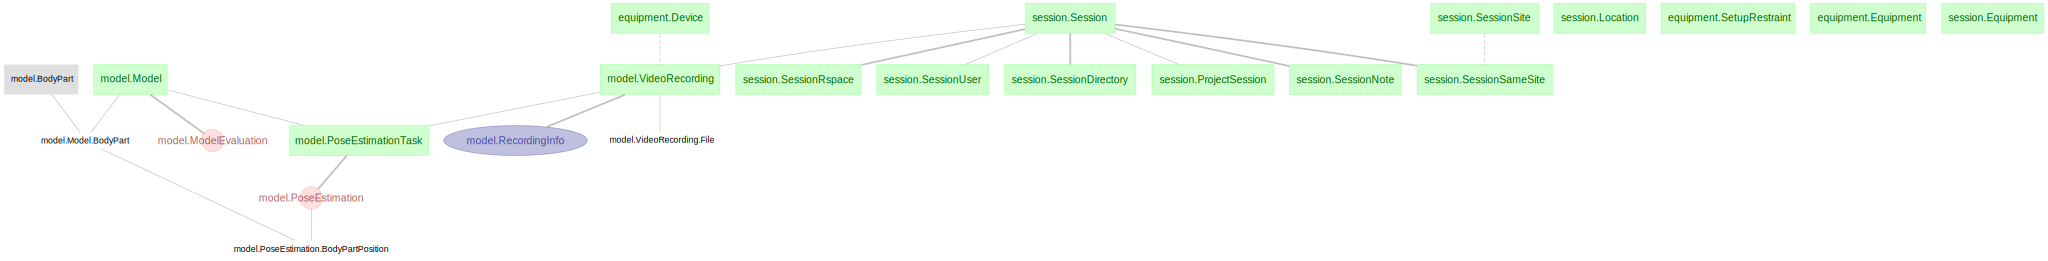

In [12]:
dj.Diagram(model) + dj.Diagram(equipment) + dj.Diagram(session)

In [13]:
    # from adamacs.ingest.dlc import ingest_dlc_items
    # ingest_dlc_items()

In [14]:
# model.VideoRecording().drop()
# model.Model.delete()

In [15]:
train.schema.list_tables()

['video_set',
 'video_set__file',
 '#training_param_set',
 'training_task',
 '__model_training']

### Manual

The same training parameters as above can be manually inserted as follows.

In [16]:
import yaml
from element_interface.utils import find_full_path
from adamacs.paths import get_dlc_root_data_dir
import pathlib
# config_path = find_full_path(get_dlc_root_data_dir(), 
                            #  'from_top_tracking-DJ-2022-02-23/config.yaml')
config_path = find_full_path(get_dlc_root_data_dir(), 
                             'Topcam_2bin_wtscope-NK-2023-09-11/config.yaml')

In [17]:
model.VideoRecording.File() 

session_id,recording_id,file_id,"file_path filepath of video, relative to root data directory"
sess9FB2LN5C,scan9FB2LN5C,1,/datajoint-data/data/tobiasr/DB_WEZ-8701_2022-03-18_scan9FB2LN5C_sess9FB2LN5C/scan9FB2LN5C_top_video_2022-03-18T16_55_33.mp4
sess9FJ842C3,scan9FJ842C3,0,/datajoint-data/data/tobiasr/RN_OPI-1681_2023-07-24_scan9FJ842C3_sess9FJ842C3/scan9FJ842C3_top_video_2023-07-24T16_38_06.mp4


In [18]:
scansi = "scan9FJ842C3"
scan_key = (scan.Scan & f'scan_id = "{scansi}"').fetch('KEY')[0] 
moviepath = str(list(pathlib.Path((scan.ScanPath() & scan_key).fetch("path")[0]).glob("*top*.mp4*"))[0])

key = {'session_id': scan_key["session_id"],
       'recording_id': scan_key["scan_id"], 
       'camera': "mini2p1_top", # Currently 'scanner' due to in equipment tables
}
model.VideoRecording.insert1(key, skip_duplicates=True)
# do not include an initial `/` in relative file paths   
key.update({'file_path': moviepath,
            'file_id': 0})
model.VideoRecording.File.insert1(key, ignore_extra_fields=True, skip_duplicates=True)

In [19]:
scansi = "scan9FB2LN5C"
scan_key = (scan.Scan & f'scan_id = "{scansi}"').fetch('KEY')[0] 
moviepath = str(list(pathlib.Path((scan.ScanPath() & scan_key).fetch("path")[0]).glob("*top*.mp4*"))[0])

key = {'session_id': scan_key["session_id"],
       'recording_id': scan_key["scan_id"], 
       'camera': "mini2p1_top", # Currently 'scanner' due to in equipment tables
}
model.VideoRecording.insert1(key, skip_duplicates=True)
# do not include an initial `/` in relative file paths   
key.update({'file_path': moviepath,
            'file_id': 1})
model.VideoRecording.File.insert1(key, ignore_extra_fields=True, skip_duplicates=True)

In [20]:
scansi = "scan9FHELAYA"
scan_key = (scan.Scan & f'scan_id = "{scansi}"').fetch('KEY')[0] 
moviepath = str(list(pathlib.Path((scan.ScanPath() & scan_key).fetch("path")[0]).glob("*top*.mp4"))[0])
# moviepath = str(list(pathlib.Path((scan.ScanPath() & scan_key).fetch("path")[0]).glob("*top*.mp4-copy.mp4"))[0])

key = {'session_id': scan_key["session_id"],
       'recording_id': scan_key["scan_id"], 
       'camera': "mini2p1_top", # Currently 'scanner' due to in equipment tables
}
model.VideoRecording.insert1(key, skip_duplicates=True)
# do not include an initial `/` in relative file paths   
key.update({'file_path': moviepath,
            'file_id': 2})
model.VideoRecording.File.insert1(key, ignore_extra_fields=True, skip_duplicates=True)

IndexError: list index out of range

## Model Training

The `TrainingTask` table queues up training. To launch training from a different machine, one needs to edit DLC's config files to reflect updated paths. For training, this includes `dlc-models/*/*/train/pose_cfg.yaml`

`CB DEV NOTE:` I'm missing the following videos used to originally train the model:
- top_video2022-02-17T15_56_10.mp4
- top_video2022-02-21T12_18_09.mp4

#### DeepLabcut Tables

The `VideoSet` table in the `train` schema retains records of files generated in the video labeling process (e.g., `h5`, `csv`, `png`). DeepLabCut will refer to the `mat` file located under the `training-datasets` directory.

We recommend storing all paths as relative to the root in your config.

In [21]:
# train.VideoSet.delete()

In [22]:
train.VideoSet.insert1({'video_set_id': 0}, skip_duplicates=True)
project_folder = 'from_top_tracking-DJ-2022-02-23/'
training_files = ['labeled-data/exp9FANLWRZ_top_video2022-02-21T12_18_09/CollectedData_DJ.h5',
                  'labeled-data/exp9FANLWRZ_top_video2022-02-21T12_18_09/CollectedData_DJ.csv',
                  'labeled-data/exp9FANLWRZ_top_video2022-02-21T12_18_09/img00674.png',
                  'videos/exp9FANLWRZ_top_video2022-02-21T12_18_09.mp4']
for idx, filename in enumerate(training_files):
    train.VideoSet.File.insert1({'video_set_id': 0,
                                 'file_id': idx,
                                 'file_path': (project_folder + filename)}, skip_duplicates=True)
train.VideoSet.File()

video_set_id,file_id,file_path
0,0,from_top_tracking-DJ-2022-02-23/labeled-data/exp9FANLWRZ_top_video2022-02-21T12_18_09/CollectedData_DJ.h5
0,1,from_top_tracking-DJ-2022-02-23/labeled-data/exp9FANLWRZ_top_video2022-02-21T12_18_09/CollectedData_DJ.csv
0,2,from_top_tracking-DJ-2022-02-23/labeled-data/exp9FANLWRZ_top_video2022-02-21T12_18_09/img00674.png
0,3,from_top_tracking-DJ-2022-02-23/videos/exp9FANLWRZ_top_video2022-02-21T12_18_09.mp4
1,0,Head_orientation-NK-2023-07-17/labeled-data/scan9FHF1JT7_top_video_2023-04-06T09_31_19/CollectedData_NK.h5
1,1,Head_orientation-NK-2023-07-17/labeled-data/scan9FHF1JT7_top_video_2023-04-06T09_31_19/CollectedData_NK.csv
1,2,Head_orientation-NK-2023-07-17/labeled-data/scan9FHF1JT7_top_video_2023-04-06T09_31_19/img00162.png
1,3,Head_orientation-NK-2023-07-17/videos/scan9FHF1JT7_top_video_2023-04-06T09_31_19.mp4


In [23]:
train.VideoSet.insert1({'video_set_id': 1}, skip_duplicates=True)
project_folder = 'Head_orientation-NK-2023-07-17/'
training_files = ['labeled-data/scan9FHF1JT7_top_video_2023-04-06T09_31_19/CollectedData_NK.h5',
                  'labeled-data/scan9FHF1JT7_top_video_2023-04-06T09_31_19/CollectedData_NK.csv',
                  'labeled-data/scan9FHF1JT7_top_video_2023-04-06T09_31_19/img00162.png',
                  'videos/scan9FHF1JT7_top_video_2023-04-06T09_31_19.mp4']
for idx, filename in enumerate(training_files):
    train.VideoSet.File.insert1({'video_set_id': 1,
                                 'file_id': idx,
                                 'file_path': (project_folder + filename)}, skip_duplicates=True)
train.VideoSet.File()

video_set_id,file_id,file_path
0,0,from_top_tracking-DJ-2022-02-23/labeled-data/exp9FANLWRZ_top_video2022-02-21T12_18_09/CollectedData_DJ.h5
0,1,from_top_tracking-DJ-2022-02-23/labeled-data/exp9FANLWRZ_top_video2022-02-21T12_18_09/CollectedData_DJ.csv
0,2,from_top_tracking-DJ-2022-02-23/labeled-data/exp9FANLWRZ_top_video2022-02-21T12_18_09/img00674.png
0,3,from_top_tracking-DJ-2022-02-23/videos/exp9FANLWRZ_top_video2022-02-21T12_18_09.mp4
1,0,Head_orientation-NK-2023-07-17/labeled-data/scan9FHF1JT7_top_video_2023-04-06T09_31_19/CollectedData_NK.h5
1,1,Head_orientation-NK-2023-07-17/labeled-data/scan9FHF1JT7_top_video_2023-04-06T09_31_19/CollectedData_NK.csv
1,2,Head_orientation-NK-2023-07-17/labeled-data/scan9FHF1JT7_top_video_2023-04-06T09_31_19/img00162.png
1,3,Head_orientation-NK-2023-07-17/videos/scan9FHF1JT7_top_video_2023-04-06T09_31_19.mp4


In [24]:
train.VideoSet()

video_set_id
0
1


The `params` longblob should be a dictionary that captures all items for DeepLabCut's `train_network` function. At minimum, this is the contents of the project's config file, as well as `suffle` and `trainingsetindex`, which are not included in the config. 

In [25]:
from deeplabcut import train_network
help(train_network) # for more information on optional parameters

2023-11-07 16:56:40.796300: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-07 16:56:40.911022: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/tobiasr/.local/lib/python3.8/site-packages/cv2/../../lib64:
2023-11-07 16:56:40.911048: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-11-07 16:56:40.941460: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already 

Loading DLC 2.3.5...
DLC loaded in light mode; you cannot use any GUI (labeling, relabeling and standalone GUI)
Help on function train_network in module deeplabcut.pose_estimation_tensorflow.training:

train_network(config, shuffle=1, trainingsetindex=0, max_snapshots_to_keep=5, displayiters=None, saveiters=None, maxiters=None, allow_growth=True, gputouse=None, autotune=False, keepdeconvweights=True, modelprefix='')
    Trains the network with the labels in the training dataset.
    
    Parameters
    ----------
    config : string
        Full path of the config.yaml file as a string.
    
    shuffle: int, optional, default=1
        Integer value specifying the shuffle index to select for training.
    
    trainingsetindex: int, optional, default=0
        Integer specifying which TrainingsetFraction to use.
        Note that TrainingFraction is a list in config.yaml.
    
    max_snapshots_to_keep: int or None
        Sets how many snapshots are kept, i.e. states of the trained n

Here, we give these items, load the config contents, and overwrite some defaults, including `maxiters`, to restrict our training iterations to 5.

In [ ]:
train.TrainingParamSet()

In [ ]:
import yaml

paramset_idx = 0; paramset_desc='from_top_tracking-DJ-2022-02-23'

config_path = find_full_path(get_dlc_root_data_dir()[0], 
                             paramset_desc + '/config.yaml')

with open(config_path, 'rb') as y:
    config_params = yaml.safe_load(y)
training_params = {'shuffle': '1',
                   'trainingsetindex': '0',
                   'maxiters': '5',
                   'scorer_legacy': 'False',
                   'maxiters': '5', 
                   'multianimalproject':'False'}
config_params.update(training_params)
train.TrainingParamSet.insert_new_params(paramset_idx=paramset_idx,
                                         paramset_desc=paramset_desc,
                                         params=config_params)

In [ ]:
paramset_idx = 1; paramset_desc='Head_orientation-NK-2023-07-17'

config_path = find_full_path(get_dlc_root_data_dir()[1], 
                             paramset_desc + '/config.yaml')

with open(config_path, 'rb') as y:
    config_params = yaml.safe_load(y)
training_params = {'shuffle': '1',
                   'trainingsetindex': '0',
                   'maxiters': '5',
                   'scorer_legacy': 'False',
                   'maxiters': '5', 
                   'multianimalproject':'False'}
config_params.update(training_params)
train.TrainingParamSet.insert_new_params(paramset_idx=paramset_idx,
                                         paramset_desc=paramset_desc,
                                         params=config_params)

In [ ]:
paramset_idx = 2; paramset_desc='Topcam_2bin_wtscope-NK-2023-09-11'

config_path = find_full_path(get_dlc_root_data_dir()[1], 
                             paramset_desc + '/config.yaml')

with open(config_path, 'rb') as y:
    config_params = yaml.safe_load(y)
training_params = {'shuffle': '1',
                   'trainingsetindex': '0',
                   'maxiters': '5',
                   'scorer_legacy': 'False',
                   'maxiters': '5', 
                   'multianimalproject':'False'}
config_params.update(training_params)
train.TrainingParamSet.insert_new_params(paramset_idx=paramset_idx,
                                         paramset_desc=paramset_desc,
                                         params=config_params)

In [ ]:
train.TrainingParamSet()

In [ ]:
# train.TrainingTask.delete()

In [ ]:
key={'video_set_id': 0, 
     'paramset_idx':0,
     'training_id':0, # uniquely defines training task
     'project_path':'from_top_tracking-DJ-2022-02-23/' # relative to dlc_root in dj.config
    }
train.TrainingTask.insert1(key, skip_duplicates=True)
train.TrainingTask()

In [ ]:
key={'video_set_id': 1, 
     'paramset_idx':1,
     'training_id':1, # uniquely defines training task
     'project_path':'Head_orientation-NK-2023-07-17' # relative to dlc_root in dj.config
    }
train.TrainingTask.insert1(key, skip_duplicates=True)
train.TrainingTask()

In [ ]:
(train.TrainingParamSet & "paramset_idx=1").fetch("params")

In [ ]:
# (train.TrainingTask() & ("video_set_id = 1")).delete()
train.TrainingTask()

In [ ]:
train.ModelTraining.populate()

To start training from a previous instance, one would need to 
[edit the relevant config file](https://github.com/DeepLabCut/DeepLabCut/issues/70) and
adjust the `maxiters` paramset (if present) to a higher threshold (e.g., 10 for 5 more itterations).
Emperical work from the Mathis team suggests 200k iterations for any true use-case.

## Tracking Joints/Body Parts

The `model` schema uses a lookup table for managing Body Parts tracked across models.

In [26]:
model.Model()

model_name User-friendly model name,task Task in the config yaml,date Date in the config yaml,iteration Iteration/version of this model,"snapshotindex which snapshot for prediction (if -1, latest)",shuffle Shuffle (1) or not (0),trainingsetindex Index of training fraction list in config.yaml,scorer Scorer/network name - DLC's GetScorerName(),config_template Dictionary of the config for analyze_videos(),project_path DLC's project_path in config relative to root,model_prefix,model_description,paramset_idx
from_top_tracking-DJ,Topcam_2bin_wtscope,Sep11,0,-3,1,0,DLC_resnet50_Topcam_2bin_wtscopeSep11shuffle1_130000,=BLOB=,Topcam_2bin_wtscope-NK-2023-09-11,,"From Top, trained 5 iterations",0
Head_orientation-NK-2023-07-17,Head_orientation,Jul17,0,3,1,0,DLC_resnet50_Head_orientationJul17shuffle1_90000,=BLOB=,Head_orientation-NK-2023-07-17,,"From Top, mouse without anything",1


In [ ]:
model.BodyPart()

This table is equipped with two helper functions. First, we can identify all the new body parts from a given config file.

In [27]:
from adamacs.paths import get_dlc_root_data_dir
config_path = find_full_path(get_dlc_root_data_dir()[1], 
                             paramset_desc + '/config.yaml')
model.BodyPart.extract_new_body_parts(config_path)

NameError: name 'paramset_desc' is not defined

Now, we can make a list of descriptions in the same order, and insert them into the table

In [ ]:
model.BodyPart()

In [ ]:
# Will be inserted with model insertion
# bp_desc=['Body Center', 'Head', 'Base of Tail']
# model.BodyPart.insert_from_config(config_path,bp_desc)

If we skip this step, body parts (without descriptions) will be added when we insert a model. We can [update](https://docs.datajoint.org/python/v0.13/manipulation/3-Cautious-Update.html) empty descriptions at any time.

## Declaring a Model

If training appears successful, the result can be inserted into the `Model` table for automatic evaluation.

In [ ]:
# paramset_desc='from_top_tracking-DJ-2022-02-23'
paramset_desc='Topcam_2bin_wtscope-NK-2023-09-11'

config_path = find_full_path(get_dlc_root_data_dir()[0], 
                             paramset_desc + '/config.yaml')

In [ ]:
model.Model.insert_new_model(model_name='from_top_tracking-DJ',dlc_config=config_path,
                             shuffle=1,trainingsetindex=0,
                             model_description='From Top, trained 5 iterations',
                             paramset_idx=0)

In [35]:
paramset_desc='Head_orientation-NK-2023-07-17'
# paramset_desc='Topcam_2bin_wtscope-NK-2023-09-11'

config_path = find_full_path(get_dlc_root_data_dir()[1], 
                             paramset_desc + '/config.yaml')

In [ ]:
config_path

In [36]:
model.Model.insert_new_model(model_name=paramset_desc,dlc_config=config_path,
                             shuffle=1,trainingsetindex=0,
                             model_description='From Top, mouse without anything',
                             paramset_idx=1)

--- DLC Model specification to be inserted ---
	model_name: Head_orientation-NK-2023-07-17
	model_description: From Top, mouse without anything
	scorer: DLC_resnet50_Head_orientationJul17shuffle1_90000
	task: Head_orientation
	date: Jul17
	iteration: 0
	snapshotindex: 3
	shuffle: 1
	trainingsetindex: 0
	project_path: Head_orientation-NK-2023-07-17
	paramset_idx: 1
	-- Template/Contents of config.yaml --
		Task: Head_orientation
		scorer: NK
		date: Jul17
		multianimalproject: False
		identity: None
		project_path: /datajoint-data/models/tobiasr/NK_DLC_tracking/Head_orientation-NK-2023-07-17
		video_sets: {'/datajoint-data/models/tobiasr/DeepLabCutModels/NK_DLC_tracking/Head_orientation-NK-2023-07-17/videos/scan9FHF1JT7_top_video_2023-04-06T09_31_19.mp4': {'crop': '0, 1000, 0, 1000'}}
		bodyparts: ['left_ear', 'right_ear', 'nose', 'head_middle', 'neck', 'body_middle', 'tail']
		start: 0
		stop: 1
		numframes2pick: 100
		skeleton: [['bodypart1', 'bodypart2'], ['objectA', 'bodypart3']]
		

DuplicateError: ("Duplicate entry 'Head_orientation-NK-2023-07-17' for key 'PRIMARY'", 'To ignore duplicate entries in insert, set skip_duplicates=True')

In [ ]:
model.VideoRecording()

In [29]:
model.VideoRecording * model.VideoRecording.File() * session.SessionUser * subject.User() * session.Session() * scan.ScanInfo * scan.ScanInfo.Field()

session_id,recording_id,file_id,user_id,scan_id,field_idx,camera,"file_path filepath of video, relative to root data directory",name,shorthand TR: added name_FirstInitialSurname shorthand,initials Update after pyrat ingestion,email TR: for completeness' sake also email,"lab short lab name, pyrat labid",subject PyRat import uses this for earmark value,session_datetime,nfields number of fields,nchannels number of channels,ndepths Number of scanning depths (planes),nframes number of recorded frames,nrois number of ROIs (see scanimage's multi ROI imaging),x (um) ScanImage's 0 point in the motor coordinate system,y (um) ScanImage's 0 point in the motor coordinate system,z (um) ScanImage's 0 point in the motor coordinate system,fps (Hz) frames per second - Volumetric Scan Rate,bidirectional true = bidirectional scanning,usecs_per_line microseconds per scan line,fill_fraction raster scan temporal fill fraction (see scanimage),scan_datetime datetime of the scan,scan_duration (seconds) duration of the scan,userfunction_info string argument of file consolidation userfunction 1,px_height height in pixels,px_width width in pixels,um_height height in microns,um_width width in microns,zoom scan zoom factor,field_x (um) center of field in the motor coordinate system,field_y (um) center of field in the motor coordinate system,field_z (um) relative depth of field,delay_image (ms) delay between the start of the scan and pixels in this field,roi the scanning roi (as recorded in the acquisition software) containing this field - only relevant to mesoscale scans
sess9FB2LN5C,scan9FB2LN5C,1,4,scan9FB2LN5C,0,mini2p1_top,/datajoint-data/data/tobiasr/DB_WEZ-8701_2022-03-18_scan9FB2LN5C_sess9FB2LN5C/scan9FB2LN5C_top_video_2022-03-18T16_55_33.mp4,Bühler Daniel,danielb,DB,Db247@uni-bonn.de,Rose,WEZ-8701,2022-03-18 00:00:00,1,2,1,5000,0,0.0,0.0,0.0,15.3846,1,250.0,0.712867,None,325.0,openfield,256,256,202.5,202.5,1.0,nan,nan,nan,=BLOB=,None
sess9FJ842C3,scan9FJ842C3,0,7,scan9FJ842C3,0,mini2p1_top,/datajoint-data/data/tobiasr/RN_OPI-1681_2023-07-24_scan9FJ842C3_sess9FJ842C3/scan9FJ842C3_top_video_2023-07-24T16_38_06.mp4,Narayanamurthy Rukhmani,rukhun,RN,rnar@uni-bonn.de,Rose,OPI-1681,2023-07-24 00:00:00,1,1,1,2000,0,0.0,0.0,0.0,7.63354,1,250.001,0.9,None,262.002,openfield,512,512,162.969,162.969,1.0,nan,nan,nan,=BLOB=,None


In [37]:
model.Model().fetch("config_template")

array([{'Task': 'Topcam_2bin_wtscope', 'scorer': 'NK', 'date': 'Sep11', 'multianimalproject': False, 'identity': None, 'project_path': '/datajoint-data/models/tobiasr/NK_DLC_tracking/Topcam_2bin_wtscope-NK-2023-09-11', 'video_sets': {'C:\\Git\\DeepLabCut\\Projects\\Topcam_2bin_wtscope-NK-2023-09-11\\videos\\scan9FJZH7V8_top_video_2023-09-08T15_43_50.mp4': {'crop': '0, 500, 0, 500'}, 'C:\\Git\\DeepLabCut\\Projects\\Topcam_2bin_wtscope-NK-2023-09-11\\videos\\scan9FJU4MXH_top_video_2023-08-30T16_05_36.mp4': {'crop': '0, 500, 0, 500'}, 'C:\\Git\\DeepLabCut\\Projects\\Topcam_2bin_wtscope-NK-2023-09-11\\videos\\scan9FK2CQNJ_top_video_2023-09-13T11_38_15.mp4': {'crop': '0, 500, 0, 500'}}, 'bodyparts': ['left_ear', 'right_ear', 'nose', 'head_middle', 'neck', 'body_middle', 'tail'], 'start': 0, 'stop': 1, 'numframes2pick': 50, 'skeleton': [['left_ear', 'right_ear'], ['neck', 'head_middle'], ['left_ear', 'nose'], ['right_ear', 'nose'], ['left_ear', 'neck'], ['right_ear', 'neck'], ['neck', 'body_

In [38]:
model.Model()

model_name User-friendly model name,task Task in the config yaml,date Date in the config yaml,iteration Iteration/version of this model,"snapshotindex which snapshot for prediction (if -1, latest)",shuffle Shuffle (1) or not (0),trainingsetindex Index of training fraction list in config.yaml,scorer Scorer/network name - DLC's GetScorerName(),config_template Dictionary of the config for analyze_videos(),project_path DLC's project_path in config relative to root,model_prefix,model_description,paramset_idx
from_top_tracking-DJ,Topcam_2bin_wtscope,Sep11,0,-3,1,0,DLC_resnet50_Topcam_2bin_wtscopeSep11shuffle1_130000,=BLOB=,Topcam_2bin_wtscope-NK-2023-09-11,,"From Top, trained 5 iterations",0
Head_orientation-NK-2023-07-17,Head_orientation,Jul17,0,3,1,0,DLC_resnet50_Head_orientationJul17shuffle1_90000,=BLOB=,Head_orientation-NK-2023-07-17,,"From Top, mouse without anything",1


In [ ]:
model.Model.BodyPart()

## Model Evaluation

Next, all inserted models can be evaluated with a similar `populate` method, which will
insert the relevant output from DLC's `evaluate_network` function.

In [ ]:
model.ModelEvaluation.heading

In [ ]:
model.ModelEvaluation.populate()

If your project was initialized in a version of DeepLabCut other than the one you're currently using, model evaluation may report key errors. Specifically, your `config.yaml` may not specify `multianimalproject: false`.

In [ ]:
model.ModelEvaluation()

In [ ]:
model.RecordingInfo.populate()
model.RecordingInfo() * model.VideoRecording.File()

## Pose Estimation

In [31]:
model.VideoRecording.File()

session_id,recording_id,file_id,"file_path filepath of video, relative to root data directory"
sess9FB2LN5C,scan9FB2LN5C,1,/datajoint-data/data/tobiasr/DB_WEZ-8701_2022-03-18_scan9FB2LN5C_sess9FB2LN5C/scan9FB2LN5C_top_video_2022-03-18T16_55_33.mp4
sess9FJ842C3,scan9FJ842C3,0,/datajoint-data/data/tobiasr/RN_OPI-1681_2023-07-24_scan9FJ842C3_sess9FJ842C3/scan9FJ842C3_top_video_2023-07-24T16_38_06.mp4


In [39]:
scansi = "scan9FB2LN5C"
scan_key = (model.VideoRecording.File & f'recording_id = "{scansi}"').fetch('KEY')[0] 
path = (model.VideoRecording.File & scan_key).fetch("file_path")
path

array(['/datajoint-data/data/tobiasr/DB_WEZ-8701_2022-03-18_scan9FB2LN5C_sess9FB2LN5C/scan9FB2LN5C_top_video_2022-03-18T16_55_33.mp4'],
      dtype=object)

In [40]:
model.VideoRecording.File()

session_id,recording_id,file_id,"file_path filepath of video, relative to root data directory"
sess9FB2LN5C,scan9FB2LN5C,1,/datajoint-data/data/tobiasr/DB_WEZ-8701_2022-03-18_scan9FB2LN5C_sess9FB2LN5C/scan9FB2LN5C_top_video_2022-03-18T16_55_33.mp4
sess9FJ842C3,scan9FJ842C3,0,/datajoint-data/data/tobiasr/RN_OPI-1681_2023-07-24_scan9FJ842C3_sess9FJ842C3/scan9FJ842C3_top_video_2023-07-24T16_38_06.mp4


For demonstration purposes, we'll make a shorter video that will process relatively quickly `ffmpeg`, a DLC dependency ([more info here](https://github.com/datajoint/workflow-deeplabcut/blob/main/notebooks/00-DataDownload_Optional.ipynb))

In [ ]:
from adamacs.paths import get_dlc_root_data_dir
vid_path =  find_full_path(get_dlc_root_data_dir(), path[0][1::])
print(vid_path)
starttime = 0
duration = 10
cmd = (f'ffmpeg -n -hide_banner -loglevel error -ss {starttime} -t {duration} -i {vid_path} '
       + f'-vcodec copy -acodec copy {vid_path}-copy.mp4')
import os; os.system(cmd)

Next, we need to specify if the `PoseEstimation` table should load results from an existing file or trigger the estimation command. Here, we can also specify parameters accepted by the `analyze_videos` function as a dictionary. `task_mode` determines if pose estimation results should be loaded or triggered (i.e., load vs. trigger).

In [41]:
key = (model.VideoRecording & {'recording_id': 'scan9FB2LN5C'}).fetch1('KEY')
key.update({'model_name': 'Head_orientation-NK-2023-07-17', 'task_mode': 'trigger'})
key



{'session_id': 'sess9FB2LN5C',
 'recording_id': 'scan9FB2LN5C',
 'model_name': 'Head_orientation-NK-2023-07-17',
 'task_mode': 'trigger'}

The `PoseEstimationTask` table queues items for pose estimation. Additional parameters are passed to DLC's `analyze_videos` function.

In [42]:
model.PoseEstimationTask()

session_id,recording_id,model_name User-friendly model name,task_mode load results or trigger computation,pose_estimation_output_dir output dir relative to the root dir,"pose_estimation_params analyze_videos params, if not default"


In [43]:
train.ModelTraining()

video_set_id,paramset_idx,training_id,"latest_snapshot latest exact snapshot index (i.e., never -1)",config_template stored full config file


In [44]:
# model.PoseEstimationTask.insert_estimation_task(key, key["model_name"], analyze_videos_params={'save_as_csv':True})
model.PoseEstimationTask.insert_estimation_task(key, key["model_name"], analyze_videos_params={'save_as_csv':True, 'dynamic':(True,.5,100)}) # dynamic cropping

In [45]:
model.RecordingInfo.populate()
model.RecordingInfo()

session_id,recording_id,px_height height in pixels,px_width width in pixels,nframes number of frames,fps (Hz) frames per second,recording_datetime Datetime for the start of the recording,recording_duration video duration (s) from nframes / fps
sess9FB2LN5C,scan9FB2LN5C,500,500,18000,60,None,300.0
sess9FJ842C3,scan9FJ842C3,1000,1000,15851,60,None,264.183


In [46]:
model.PoseEstimation.populate()

Using snapshot-90000 for model /datajoint-data/models/tobiasr/NK_DLC_tracking/Head_orientation-NK-2023-07-17/dlc-models/iteration-0/Head_orientationJul17-trainset95shuffle1
Starting analysis in dynamic cropping mode with parameters: (True, 0.5, 100)
Switching batchsize to 1, num_outputs (per animal) to 1 and TFGPUinference to False (all these features are not supported in this mode).


/home/tobiasr/miniconda3/envs/dj_pure/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
2023-11-07 17:51:58.302338: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/tobiasr/.local/lib/python3.8/site-packages/cv2/../../lib64:
2023-11-07 17:51:58.302521: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-11-07 17:51:58.302540: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (tatchu3): /proc/driver/nvidia/version does not exist
2023-11-07 17:51:58.302947: I tensorflow/core/platform/cpu_feature_guard.cc:

Starting to analyze %  /datajoint-data/data/tobiasr/DB_WEZ-8701_2022-03-18_scan9FB2LN5C_sess9FB2LN5C/scan9FB2LN5C_top_video_2022-03-18T16_55_33.mp4
Loading  /datajoint-data/data/tobiasr/DB_WEZ-8701_2022-03-18_scan9FB2LN5C_sess9FB2LN5C/scan9FB2LN5C_top_video_2022-03-18T16_55_33.mp4
Duration of video [s]:  300.0 , recorded with  60.0 fps!
Overall # of frames:  18000  found with (before cropping) frame dimensions:  500 500
Starting to extract posture


100%|██████████| 18000/18000 [12:51<00:00, 23.34it/s]


Saving results in /datajoint-data/data/tobiasr/DB_WEZ-8701_2022-03-18_scan9FB2LN5C_sess9FB2LN5C/device_mini2p1_top_recording_scan9FB2LN5C_model_Head_orientation-NK-2023-07-17...
Saving csv poses!
The videos are analyzed. Now your research can truly start! 
 You can create labeled videos with 'create_labeled_video'
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.


In [ ]:
model.PoseEstimationTask().delete()
model.PoseEstimation().delete()

# Data Evaluation

By default, DataJoint will store the results of pose estimation in a subdirectory
>  processed_dir / videos / device_<#>_recording_<#>_model_<name>

Pulling processed_dir from `get_dlc_processed_dir`, and device/recording information 
from the `VideoRecording` table. The model name is taken from the primary key of the
`Model` table, with spaced replaced by hyphens.
    
We can get this estimation directly as a pandas dataframe.

In [47]:
(model.PoseEstimation() * session.Session * session.SessionUser * subject.User()).fetch(format = "frame", order_by = "session_datetime")

,,,,pose_estimation_time,subject,session_datetime,name,shorthand,initials,email,lab
session_id,recording_id,model_name,user_id,,,,,,,,
sess9FB2LN5C,scan9FB2LN5C,Head_orientation-NK-2023-07-17,4,2023-11-07 18:04:50,WEZ-8701,2022-03-18,Bühler Daniel,danielb,DB,Db247@uni-bonn.de,Rose


In [49]:
scansi = "scan9FB2LN5C"
scan_key = (model.PoseEstimation & f'recording_id = "{scansi}"').fetch('KEY')[0] 
path = (model.VideoRecording.File & scan_key).fetch("file_path")
path

array(['/datajoint-data/data/tobiasr/DB_WEZ-8701_2022-03-18_scan9FB2LN5C_sess9FB2LN5C/scan9FB2LN5C_top_video_2022-03-18T16_55_33.mp4'],
      dtype=object)

In [50]:
imaging.Curation()

session_id,scan_id,paramset_idx,curation_id,curation_time time of generation of this set of curated results,"curation_output_dir output directory of the curated results, relative to root data directory",manual_curation has manual curation been performed on this result?,curation_note
sess9FJ842C3,scan9FJ842C3,0,1,2023-11-07 15:44:19,/datajoint-data/data/tobiasr/RN_OPI-1681_2023-07-24_scan9FJ842C3_sess9FJ842C3,0,
sess9FKW82R3,scan9FKW82R3,0,1,2023-11-07 13:40:24,/datajoint-data/data/tobiasr/JJ_ROS-1604_2023-11-02_scan9FKW82R3_sess9FKW82R3,0,
sess9FKW82R3,scan9FKW82R3,0,2,2023-11-07 13:40:24,/datajoint-data/data/tobiasr/JJ_ROS-1604_2023-11-02_scan9FKW82R3_sess9FKW82R3,0,


In [51]:
(model.PoseEstimation.BodyPartPosition() & scan_key & 'body_part = "head_middle"').fetch("x_pos", "y_pos")

[array([array([237.60452414, 250.80778667, 249.91791904, ..., 115.78650405,
               115.69831222, 115.58460364])                                ],
       dtype=object),
 array([array([316.86300623, 282.24885416, 285.32550979, ..., 168.81627899,
               168.38715887, 168.58622289])                                ],
       dtype=object)]

In [53]:
#reduce dataframe to xy coordinates
df=model.PoseEstimation.get_trajectory(scan_key)
df_xy = df.iloc[:,df.columns.get_level_values(2).isin(["x","y"])]['Head_orientation-NK-2023-07-17']
# df_xy.mean()
df_xy

bodyparts body_middle             head_middle                left_ear  \
coords              x           y           x           y           x   
0          245.210500  300.892605  237.604524  316.863006  251.555838   
1          246.211318  303.964208  250.807787  282.248854  244.669691   
2          244.918127  302.384315  249.917919  285.325510  245.411916   
3          243.758884  302.094733  247.375341  285.104280  243.631439   
4          245.869614  303.216443  251.727799  286.742779  247.101154   
...               ...         ...         ...         ...         ...   
17995      106.366572  181.141726  116.240764  166.088985  108.504154   
17996      103.864295  185.661484  115.979902  169.374073  108.111101   
17997      103.383309  184.910649  115.786504  168.816279  107.934765   
17998      106.013699  183.751561  115.698312  168.387159  108.262958   
17999      105.899504  184.263124  115.584604  168.586223  108.642695   

bodyparts                    neck                    nose              \
coords              y           x           y           x           y   
0          272.792832  250.481691  286.356891  235.460761  329.171641   
1          280.814290  249.757620  288.913718  235.447193  330.330969   
2          276.677530  245.057815  298.888165  232.305737  331.344867   
3          276.394689  240.231870  316.715412  237.285357  330.154955   
4          278.114369  246.880907  299.278903  233.351740  333.230880   
...               ...         ...         ...         ...         ...   
17995      161.972440  114.225550  172.505881  122.323562  160.925137   
17996      165.004226  114.369572  175.586448  122.630785  160.525506   
17997      164.161884  108.514101  169.795604  122.365352  159.994814   
17998      163.653824  114.210350  174.400444  121.794587  159.412208   
17999      164.229416  114.023776  174.656838  121.242409  159.631326   

bodyparts   right_ear                    tail              
coords              x           y           x           y  
0          261.036757  286.261532  252.308465  273.649523  
1          258.278804  289.960879  254.857272  276.816988  
2          256.892189  287.523937  251.961684  279.589131  
3          255.246432  287.713033  251.449062  279.465723  
4          258.341410  287.806501  252.623281  281.471055  
...               ...         ...         ...         ...  
17995      120.980278  174.523257   90.482788  197.265034  
17996      121.000522  177.377039   90.546118  200.416736  
17997      120.631743  176.897449   90.353332  199.578067  
17998      120.794499  176.080148   90.655712  199.792102  
17999      120.618259  176.274649   90.834644  200.367901  

[18000 rows x 14 columns]

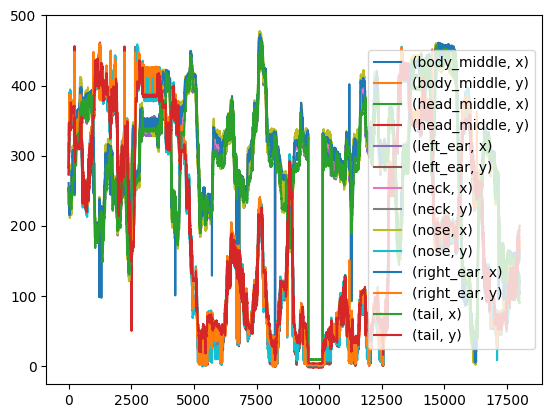

In [54]:
df_xy.plot().legend(loc='right')

In [55]:
df_flat = df_xy.copy()
df_flat.columns = df_flat.columns.map('_'.join)

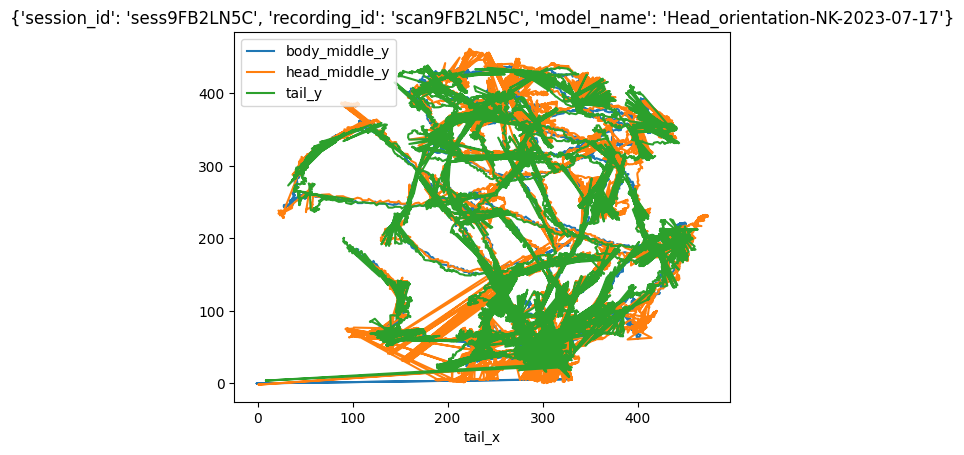

In [56]:
import matplotlib.pyplot as plt 
fig,ax=plt.subplots()
df_flat.plot(x='body_middle_x',y='body_middle_y',ax=ax)
df_flat.plot(x='head_middle_x',y='head_middle_y', ax=ax)
df_flat.plot(x='tail_x',y='tail_y', ax=ax)
plt.title(scan_key)
plt.show()

In [ ]:
destfolder = model.PoseEstimationTask.infer_output_dir(key)
destfolder

In [ ]:
key

In [ ]:
from deeplabcut.utils.make_labeled_video import create_labeled_video
import yaml
from element_interface.utils import find_full_path
from adamacs.paths import get_dlc_root_data_dir


video_path = find_full_path( # Fetch the full video path
    get_dlc_root_data_dir(), ((model.VideoRecording.File & key).fetch1("file_path"))
)

config_paths = sorted( # Of configs in the project path, defer to the datajoint-saved
    list(
        find_full_path(
            get_dlc_root_data_dir(), ((model.Model & key).fetch1("project_path"))
        ).glob("*.y*ml")
    )
)

create_labeled_video( # Pass strings to label the video
    config=str(config_paths[-1]),
    videos=str(video_path),
    destfolder=str(destfolder),
)

# list(list(pathlib.Path((model.VideoRecording.File & key).fetch1("file_path")).parent.glob("device*"))[0].glob("*.y*ml"))

In [ ]:
destfolder

In [ ]:
import pathlib
moviepath = str(list(pathlib.Path(destfolder).glob("*.mp4"))[0])
moviepath


In [ ]:
(model.VideoRecording.File & key).fetch1("file_path")

In [ ]:
list(list(pathlib.Path((model.VideoRecording.File & key).fetch1("file_path")).parent.glob("device*"))[0].glob("*.y*ml"))